In [1]:
%matplotlib inline

import random
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np
import pystan 
import pandas as pd
import seaborn as sns
import random as rd
import math
import statistics as st
from matplotlib.backends.backend_pdf import PdfPages
import pickle
from tqdm.notebook import tqdm as tqdm

In [2]:
model = """
data {
    int N;                                //Data number
    real T[N];
    real pH[N];
}

parameters {
    real<lower=0> A;
    real<lower=-6, upper=0> logk;
    real<lower=0, upper=4> Lowest;
    real<lower=0> sigma;     //s.d. of Retention time
}


model {
    sigma ~ normal(0, 0.01);
    Lowest ~ normal(1.5, 0.05);
    for(n in 1:N) {
        pH[n] ~ normal(Lowest+A*exp(-(10^logk)*T[n]), sigma);
    }
}

generated quantities {
    real<lower=0> k;
    k = 10^logk;
}
"""
sm = pystan.StanModel(model_code=model)

with open('Stan model for pH change.pkl', 'wb') as f:

    pickle.dump(sm, f)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b97d96415c0a02309b3f86271ea3fc89 NOW.


In [3]:
#### Data Import
data = pd.read_csv('Data/Gastric Data/pH changes quantile (Russel, 1993).csv')
data['Time']

0       0
1       5
2      10
3      15
4      20
     ... 
93    220
94    225
95    230
96    235
97    240
Name: Time, Length: 98, dtype: int64

In [4]:
datum = data[data['Age'] == 1]

In [5]:
rep = 100
rep_sq = int(rep/4)
observed_pH = np.zeros((rep*len(datum["Time"]),2),dtype=float)
observed_pH_Age = np.zeros((rep*len(datum["Age"]),1),dtype = int)

for t in range(len(datum["Time"])):
    for n in range(rep):
        observed_pH[t*rep+n,0]=deepcopy(datum["Time"][t])*60
        observed_pH_Age[t*rep+n,0]=datum["Age"][t]
        
observed_pH_Age = observed_pH_Age[:,0]

for t in range(len(datum["Time"])):
    i=0
    for k in range(rep_sq):
        observed_pH[int(t*rep+i*rep_sq+k),1]=rd.uniform(datum["1st quantile"][t], datum["Upper"][t])
    i=1
    for k in range(rep_sq):
        observed_pH[int(t*rep+i*rep_sq+k),1]=rd.uniform(datum["median"][t], datum["1st quantile"][t])
    i=2
    for k in range(rep_sq):
        observed_pH[int(t*rep+i*rep_sq+k),1]=rd.uniform(datum["3rd quantile"][t], datum["median"][t])
    i=3
    for k in range(rep_sq):
        observed_pH[int(t*rep+i*rep_sq+k),1]=rd.uniform(datum["lower"][t], datum["3rd quantile"][t])
        
observed_pH=pd.DataFrame(observed_pH,dtype="float",columns=["Time","pH"])
observed_pH_Age=pd.DataFrame(observed_pH_Age,dtype="int",columns=["Age"])

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  if __name__ == '__main__':


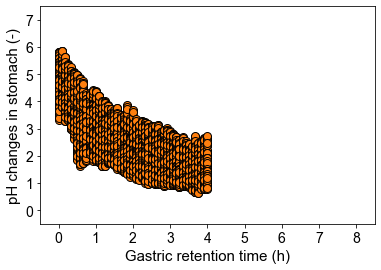

In [6]:
pdf = PdfPages("pH change/plot/pH change.pdf")
plt.rcParams["font.family"] = "Arial"
plt.xticks(size=14)
plt.yticks(size=14)


plt.figure(1,figsize=(15/2*2,15/3*2))

plt.axis([-0.5,8.5,-0.5,7.5],fontname="Arial")
plt.xticks(size=14)
plt.yticks(size=14)
plt.ylabel("pH changes in stomach (-)",size=15,fontname="Arial")
plt.xlabel("Gastric retention time (h)",size=15,fontname="Arial")

plt.plot(
        observed_pH["Time"]/3600, observed_pH["pH"],
        marker="o",
        markersize=8,
        markerfacecolor=sns.color_palette()[1],
        markeredgecolor="black",
        color="None"
    )

pdf.savefig()

pdf.close()

plt.show()

In [7]:
sm_pH_change = pickle.load(open('Stan model for pH change.pkl', 'rb'))

fit_nuts_pH_change = sm_pH_change.sampling(
    data=dict(T = observed_pH["Time"], pH = observed_pH["pH"], N = len(observed_pH["Time"])),
    iter=3000, chains=4,thin=1,warmup=500, 
    seed=12345, control=dict(adapt_delta=0.99,max_treedepth=15)
    ) 
print(fit_nuts_pH_change)


with open('fit_nuts_pH_change_younger.pkl', 'wb') as g:

    pickle.dump(fit_nuts_pH_change, g)


Inference for Stan model: anon_model_b97d96415c0a02309b3f86271ea3fc89.
4 chains, each with iter=3000; warmup=500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
A        3.28  3.7e-4   0.03   3.22   3.26   3.28    3.3   3.33   6144    1.0
logk    -3.64  1.6e-4   0.01  -3.66  -3.65  -3.64  -3.63  -3.62   4724    1.0
Lowest    1.6  3.5e-4   0.02   1.55   1.58    1.6   1.61   1.64   4262    1.0
sigma    0.54  4.3e-5 3.7e-3   0.53   0.54   0.54   0.54   0.55   7288    1.0
k      2.3e-4  8.4e-8 5.7e-6 2.2e-4 2.3e-4 2.3e-4 2.3e-4 2.4e-4   4725    1.0
lp__    -2363    0.02   1.39  -2366  -2364  -2363  -2362  -2361   3567    1.0

Samples were drawn using NUTS at Thu Jul 29 11:22:44 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  del sys.path[0]


In [8]:
samples = fit_nuts_pH_change.extract(permuted=False, inc_warmup=True)
paraname = fit_nuts_pH_change.sim["fnames_oi"]
palette = sns.color_palette()
ms = fit_nuts_pH_change.extract(permuted=False, inc_warmup=True)
iter_from = fit_nuts_pH_change.sim['warmup']
iter_range = np.arange(iter_from, ms.shape[0])
paraname = fit_nuts_pH_change.sim['fnames_oi']
num_pages = math.ceil(len(paraname)/4)

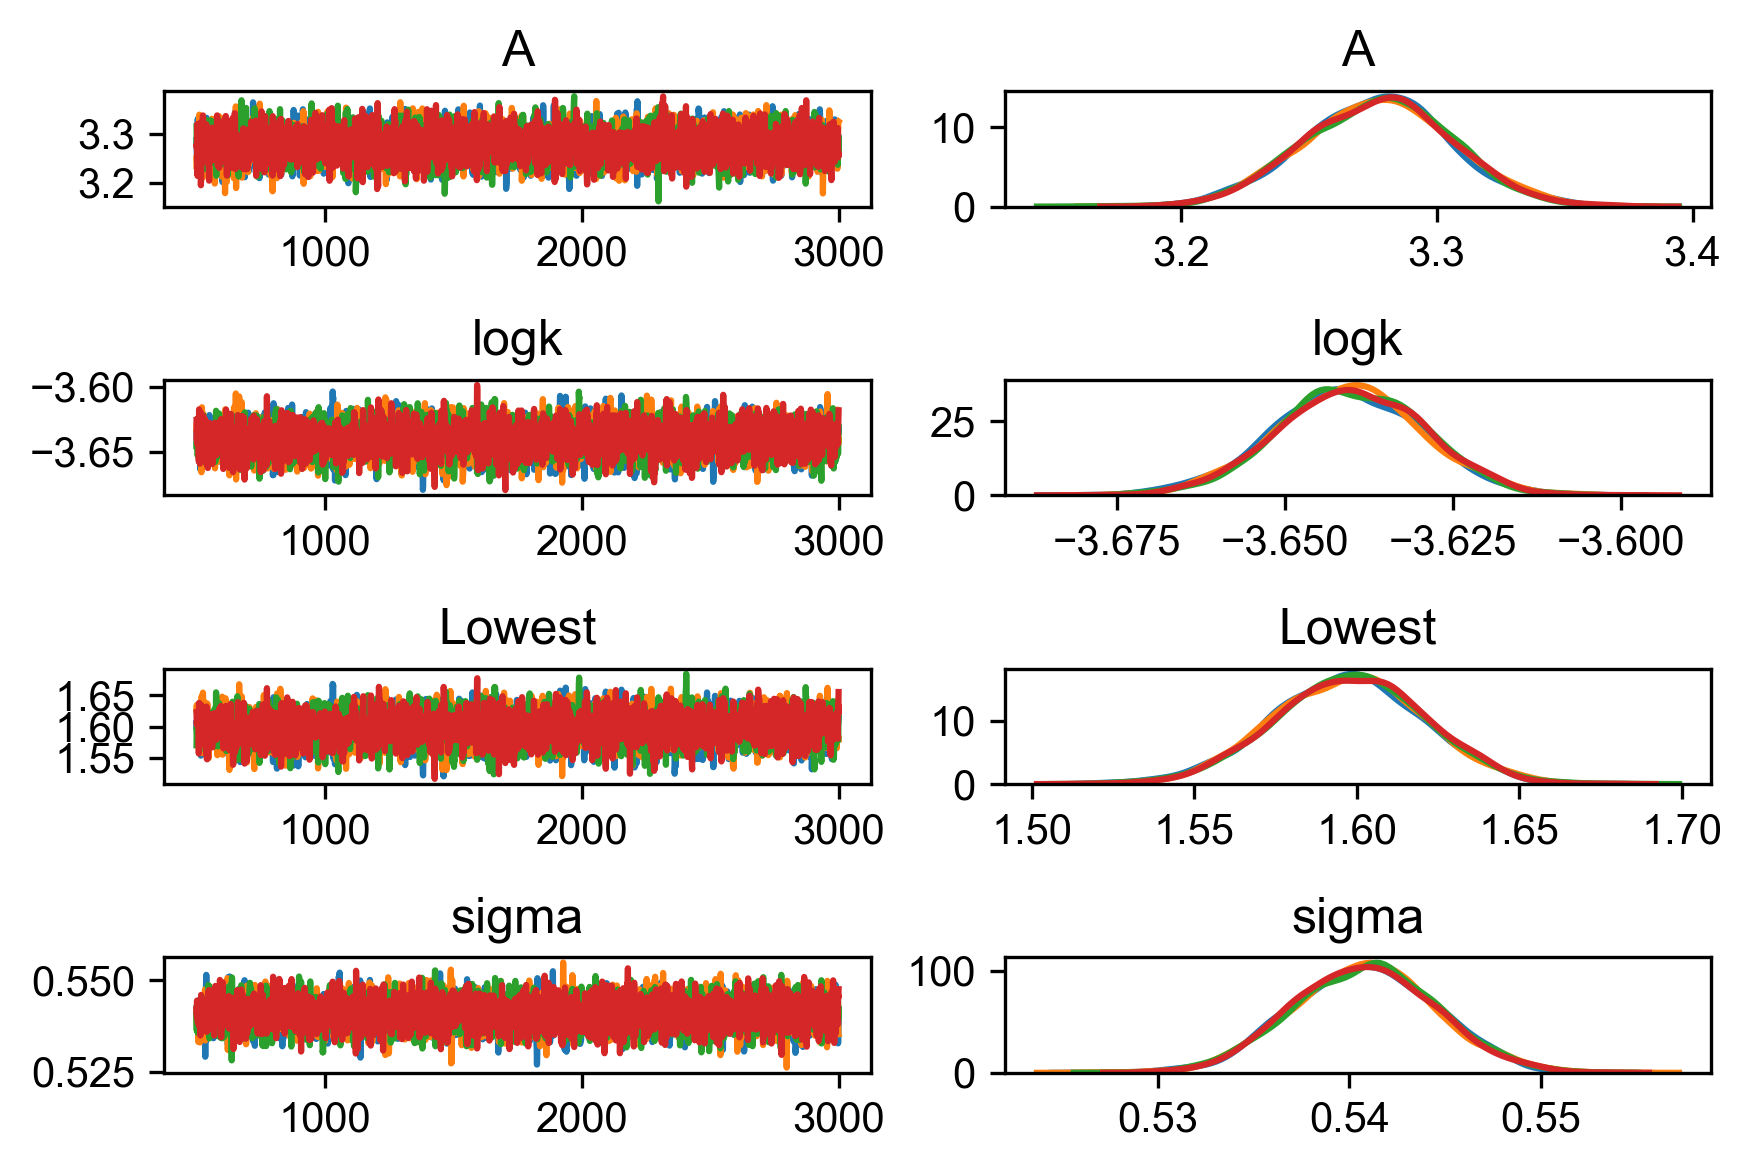

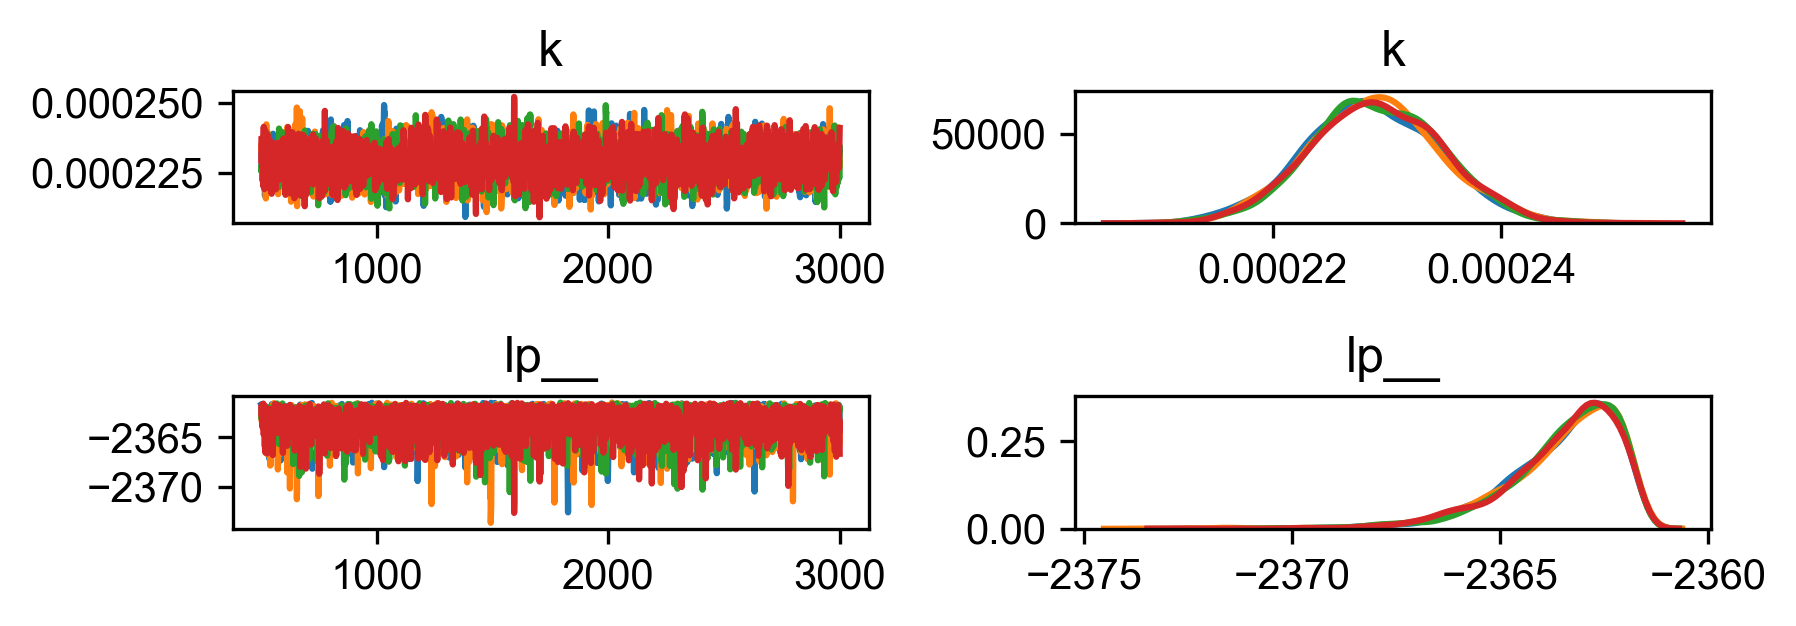

In [9]:
for pg in tqdm(range(num_pages),desc='Progress', leave=False):
    plt.figure(dpi=300)
    pdf = PdfPages("pH change/plot/traceplot/Bayesian Fitting Trace"+str(pg)+".pdf")
    for pos in range(4):
        pi = pg*4 + pos
        if pi >= len(paraname): break
        plt.subplot(4, 2, 2*pos+1)
        plt.tight_layout()
        [plt.plot(iter_range + 1, ms[iter_range,ci,pi], color=palette[ci]) for ci in range(ms.shape[1])]
        plt.title(paraname[pi])
        plt.subplot(4, 2, 2*(pos+1))
        plt.tight_layout()
        [sns.kdeplot(ms[iter_range,ci,pi], color=palette[ci]) for ci in range(ms.shape[1])]
        plt.title(paraname[pi])
    pdf.savefig()
    pdf.close()
    plt.show()

In [10]:
def Fit_Model(t,k,A,Lowest) :
    return Lowest+A*np.exp(-k*t)
def Sample_percentile(t,y_mcmc) :
    prob = [0.5,1,2.5,5,10,20,50,80,90,95,97.5,99,99.5]
    exam = [str(n) for n in prob]
    d = np.zeros((len(time_interval),len(prob)+1), dtype=float)
    for j in range(len(time_interval)):
        d[j,0] = time_interval[j]
        for i in range(len(prob)):
            d[j,i+1] = np.percentile(y_mcmc.iloc[j,:], prob[i],axis=0)
    d = pd.DataFrame(d,dtype="float",columns=["Time"]+exam)
    return d

In [11]:
samples = fit_nuts_pH_change.extract(permuted=True)
time_max = 6
devide = time_max*60*60
time_interval = np.arange(0, time_max*(devide+1)/devide, time_max/devide, dtype="float")
Num_mcmc = len(samples["lp__"])
y_conf_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
y_predict_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        y_predict_mcmc[j,k] = np.random.normal(Fit_Model(time_interval[j]*3600,
                                                             samples["k"][k],
                                                             samples["A"][k],
                                                             samples["Lowest"][k]),
                                                   samples["sigma"][k]
                                                  )
y_predict_mcmc_df = pd.DataFrame(y_predict_mcmc)
y_predict_percentile = Sample_percentile(time_interval,y_predict_mcmc_df)
y_predict_percentile

,Time,0.5,1,2.5,5,10,20,50,80,90,95,97.5,99,99.5
0,0.000000,3.501493,3.632049,3.814041,3.976340,4.182290,4.425339,4.871242,5.327784,5.562243,5.748734,5.916329,6.099256,6.228734
1,0.000278,3.480646,3.619259,3.810933,3.987969,4.184374,4.426161,4.884769,5.343379,5.574255,5.774295,5.949364,6.150848,6.271018
2,0.000556,3.509703,3.670469,3.855734,4.010806,4.196606,4.430092,4.886147,5.343492,5.583421,5.792608,5.956794,6.137001,6.272503
3,0.000833,3.495100,3.604916,3.795326,3.979190,4.172361,4.407903,4.871450,5.343373,5.573023,5.763280,5.935418,6.087656,6.200022
4,0.001111,3.468879,3.630130,3.819604,3.997072,4.191885,4.434133,4.870612,5.331603,5.585195,5.789759,5.949997,6.150843,6.265141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21596,5.998889,0.225837,0.360775,0.572235,0.732469,0.934730,1.172911,1.613326,2.070661,2.312788,2.517566,2.694621,2.912704,3.032871
21597,5.999167,0.231295,0.381049,0.583703,0.742872,0.940050,1.179310,1.636853,2.083558,2.314019,2.538394,2.699395,2.909142,3.042407
21598,5.999444,0.245408,0.380927,0.573415,0.745604,0.940005,1.171540,1.635322,2.084339,2.329010,2.529687,2.701841,2.918795,3.042209
21599,5.999722,0.244196,0.375663,0.543530,0.738162,0.943882,1.179390,1.620611,2.071597,2.313442,2.502349,2.673423,2.883046,3.009865


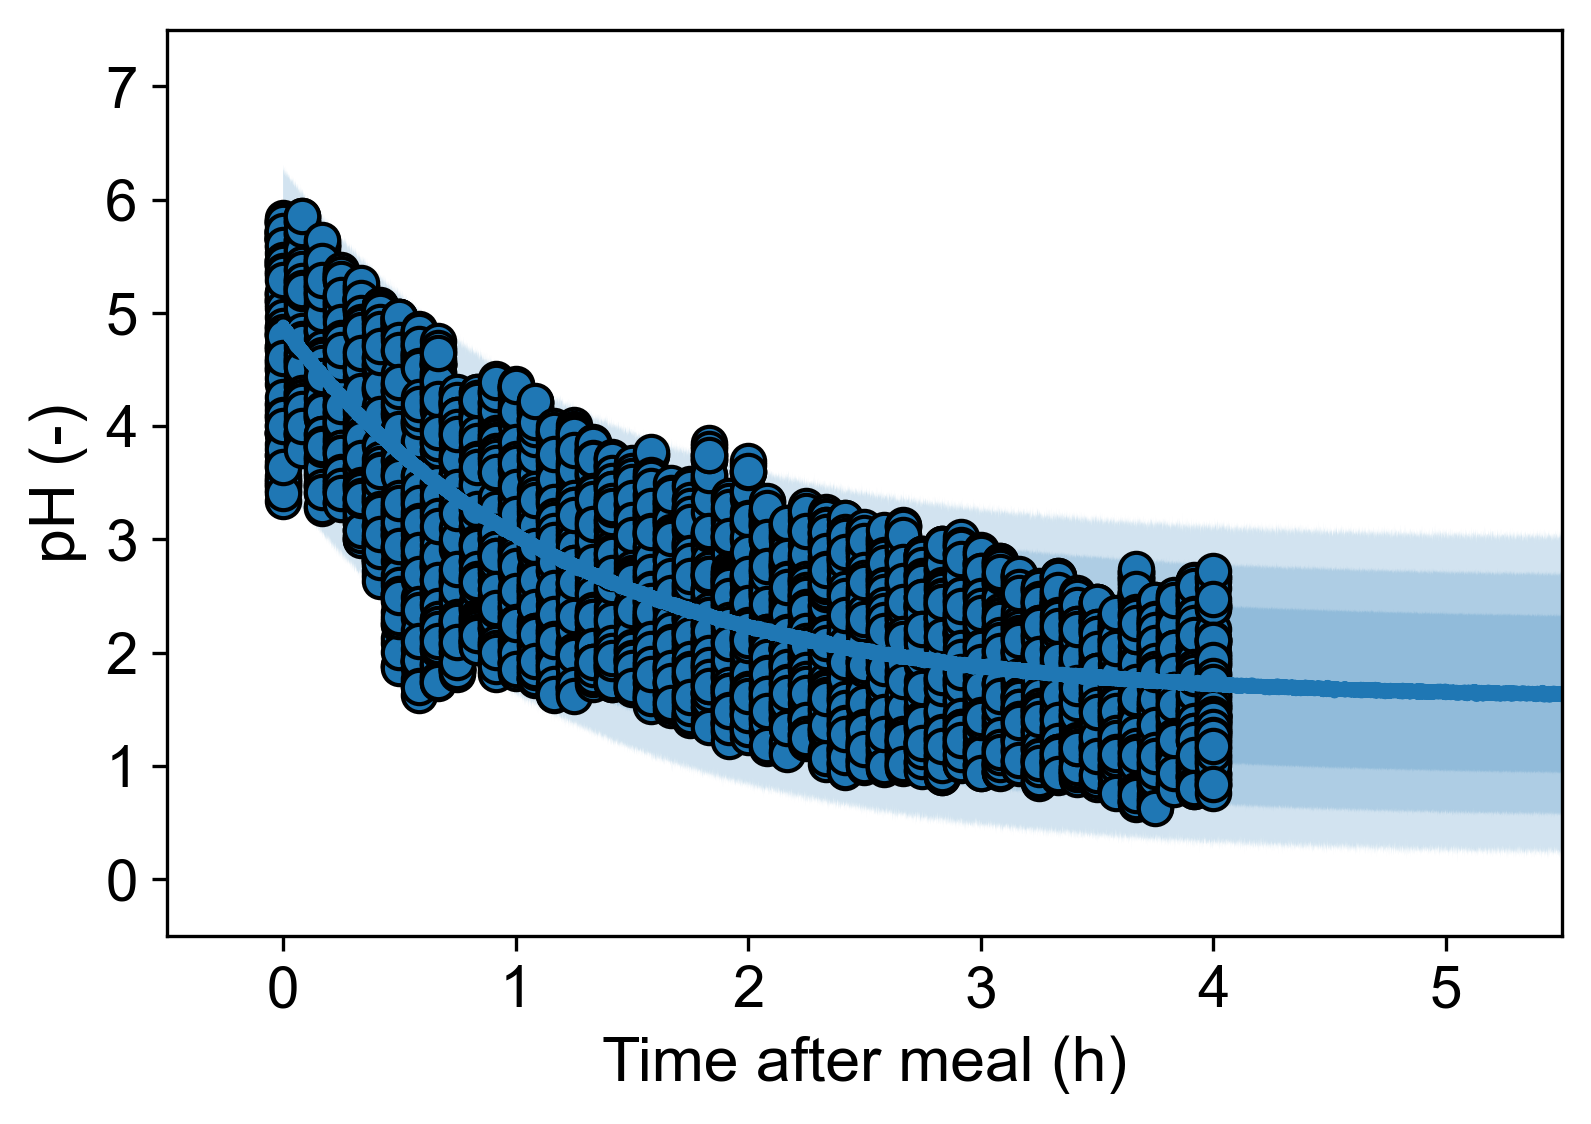

In [12]:
plt.figure(dpi=300)
plt.rcParams["font.family"] = "Arial"
plt.xticks(size=14)
plt.yticks(size=14)


time_max = 6
devide = time_max*60*60
time_interval = np.arange(0, time_max*(devide+1)/devide, time_max/devide, dtype="float")
y_predict_mcmc_df = pd.DataFrame(y_predict_mcmc)
y_predict_percentile = Sample_percentile(time_interval,y_predict_mcmc_df)
y_predict_percentile

pdf = PdfPages("pH change/plot/pH change.pdf")

plt.plot(
        observed_pH["Time"]/3600,observed_pH["pH"],
        marker="o",
        markersize=8,
        markerfacecolor=sns.color_palette()[0],
        markeredgecolor="black",
        color="None"
)
plt.plot(y_predict_percentile["Time"],y_predict_percentile["50"],color=sns.color_palette()[0],linewidth=3)
#plt.plot(y_predict_percentile["Time"],y_predict_mcmc[:,2967],color=sns.color_palette()[2],linewidth=1)
#plt.plot(y_predict_percentile["Time"],y_predict_mcmc[:,145],color=sns.color_palette()[3],linewidth=1)
#plt.plot(y_predict_percentile["Time"],y_predict_mcmc[:,8474],color=sns.color_palette()[4],linewidth=1)
plt.fill_between(y_predict_percentile["Time"],y_predict_percentile["0.5"],y_predict_percentile["99.5"],facecolor=sns.color_palette()[0],alpha=0.2)
plt.fill_between(y_predict_percentile["Time"],y_predict_percentile["2.5"],y_predict_percentile["97.5"],facecolor=sns.color_palette()[0],alpha=0.2)
plt.fill_between(y_predict_percentile["Time"],y_predict_percentile["10"],y_predict_percentile["90"],facecolor=sns.color_palette()[0],alpha=0.2)
plt.ylabel("pH (-)",size=15,fontname="Arial")
plt.xlabel("Time after meal (h)",size=15,fontname="Arial")
plt.ylim([-0.5,7.5])
plt.xlim([-0.5,5.5])


pdf.savefig()

pdf.close()

In [13]:
datum = data[data['Age'] == 2]
datum = datum.reset_index(drop=True)

In [14]:
rep = 100
rep_sq = int(rep/4)
observed_pH_elder = np.zeros((rep*len(datum["Time"]),2),dtype=float)
observed_pH_elder_Age = np.zeros((rep*len(datum["Age"]),1),dtype = int)

for t in range(len(datum["Time"])):
    for n in range(rep):
        observed_pH_elder[t*rep+n,0]=deepcopy(datum["Time"][t])*60
        observed_pH_elder_Age[t*rep+n,0]=datum["Age"][t]
        
observed_pH_elder_Age = observed_pH_elder_Age[:,0]

for t in range(len(datum["Time"])):
    i=0
    for k in range(rep_sq):
        observed_pH_elder[int(t*rep+i*rep_sq+k),1]=rd.uniform(datum["1st quantile"][t], datum["Upper"][t])
    i=1
    for k in range(rep_sq):
        observed_pH_elder[int(t*rep+i*rep_sq+k),1]=rd.uniform(datum["median"][t], datum["1st quantile"][t])
    i=2
    for k in range(rep_sq):
        observed_pH_elder[int(t*rep+i*rep_sq+k),1]=rd.uniform(datum["3rd quantile"][t], datum["median"][t])
    i=3
    for k in range(rep_sq):
        observed_pH_elder[int(t*rep+i*rep_sq+k),1]=rd.uniform(datum["lower"][t], datum["3rd quantile"][t])
        
observed_pH_elder=pd.DataFrame(observed_pH_elder,dtype="float",columns=["Time","pH"])
observed_pH_elder_Age=pd.DataFrame(observed_pH_elder_Age,dtype="int",columns=["Age"])

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  # Remove the CWD from sys.path while we load stuff.


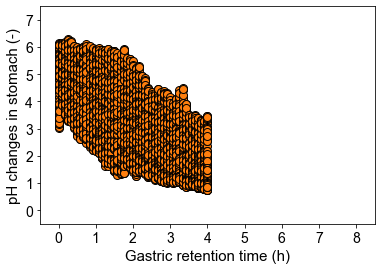

In [15]:
pdf = PdfPages("pH change/plot/pH change.pdf")

plt.rcParams["font.family"] = "Arial"
plt.xticks(size=14)
plt.yticks(size=14)


plt.figure(1,figsize=(15/2*2,15/3*2))

plt.axis([-0.5,8.5,-0.5,7.5],fontname="Arial")
plt.xticks(size=14)
plt.yticks(size=14)
plt.ylabel("pH changes in stomach (-)",size=15,fontname="Arial")
plt.xlabel("Gastric retention time (h)",size=15,fontname="Arial")

plt.plot(
        observed_pH_elder["Time"]/3600, observed_pH_elder["pH"],
        marker="o",
        markersize=8,
        markerfacecolor=sns.color_palette()[1],
        markeredgecolor="black",
        color="None"
    )

pdf.savefig()

pdf.close()

plt.show()

In [16]:
sm_pH_change = pickle.load(open('Stan model for pH change.pkl', 'rb'))

fit_nuts_pH_change = sm_pH_change.sampling(
    data=dict(T = observed_pH_elder["Time"], pH = observed_pH_elder["pH"], N = len(observed_pH_elder["Time"])),
    iter=3000, chains=4,thin=1,warmup=500, 
    seed=12345, control=dict(adapt_delta=0.99,max_treedepth=15)
    ) 
print(fit_nuts_pH_change)

with open('fit_nuts_pH_change_elder.pkl', 'wb') as g:

    pickle.dump(fit_nuts_pH_change, g)


Inference for Stan model: anon_model_b97d96415c0a02309b3f86271ea3fc89.
4 chains, each with iter=3000; warmup=500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
A        4.06  8.2e-4   0.05   3.98   4.03   4.06   4.09   4.15   3058    1.0
logk    -3.95  1.7e-4 9.8e-3  -3.97  -3.95  -3.95  -3.94  -3.93   3313    1.0
Lowest   1.21  8.1e-4   0.04   1.13   1.19   1.21   1.24    1.3   2606    1.0
sigma    0.74  6.6e-5 4.2e-3   0.73   0.73   0.74   0.74   0.74   4064    1.0
k      1.1e-4  4.4e-8 2.6e-6 1.1e-4 1.1e-4 1.1e-4 1.1e-4 1.2e-4   3309    1.0
lp__    -6361    0.03   1.43  -6365  -6362  -6361  -6360  -6359   3097    1.0

Samples were drawn using NUTS at Thu Jul 29 11:57:52 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  if sys.path[0] == '':


In [17]:
samples = fit_nuts_pH_change.extract(permuted=False, inc_warmup=True)
paraname = fit_nuts_pH_change.sim["fnames_oi"]
palette = sns.color_palette()
ms = fit_nuts_pH_change.extract(permuted=False, inc_warmup=True)
iter_from = fit_nuts_pH_change.sim['warmup']
iter_range = np.arange(iter_from, ms.shape[0])
paraname = fit_nuts_pH_change.sim['fnames_oi']
num_pages = math.ceil(len(paraname)/4)

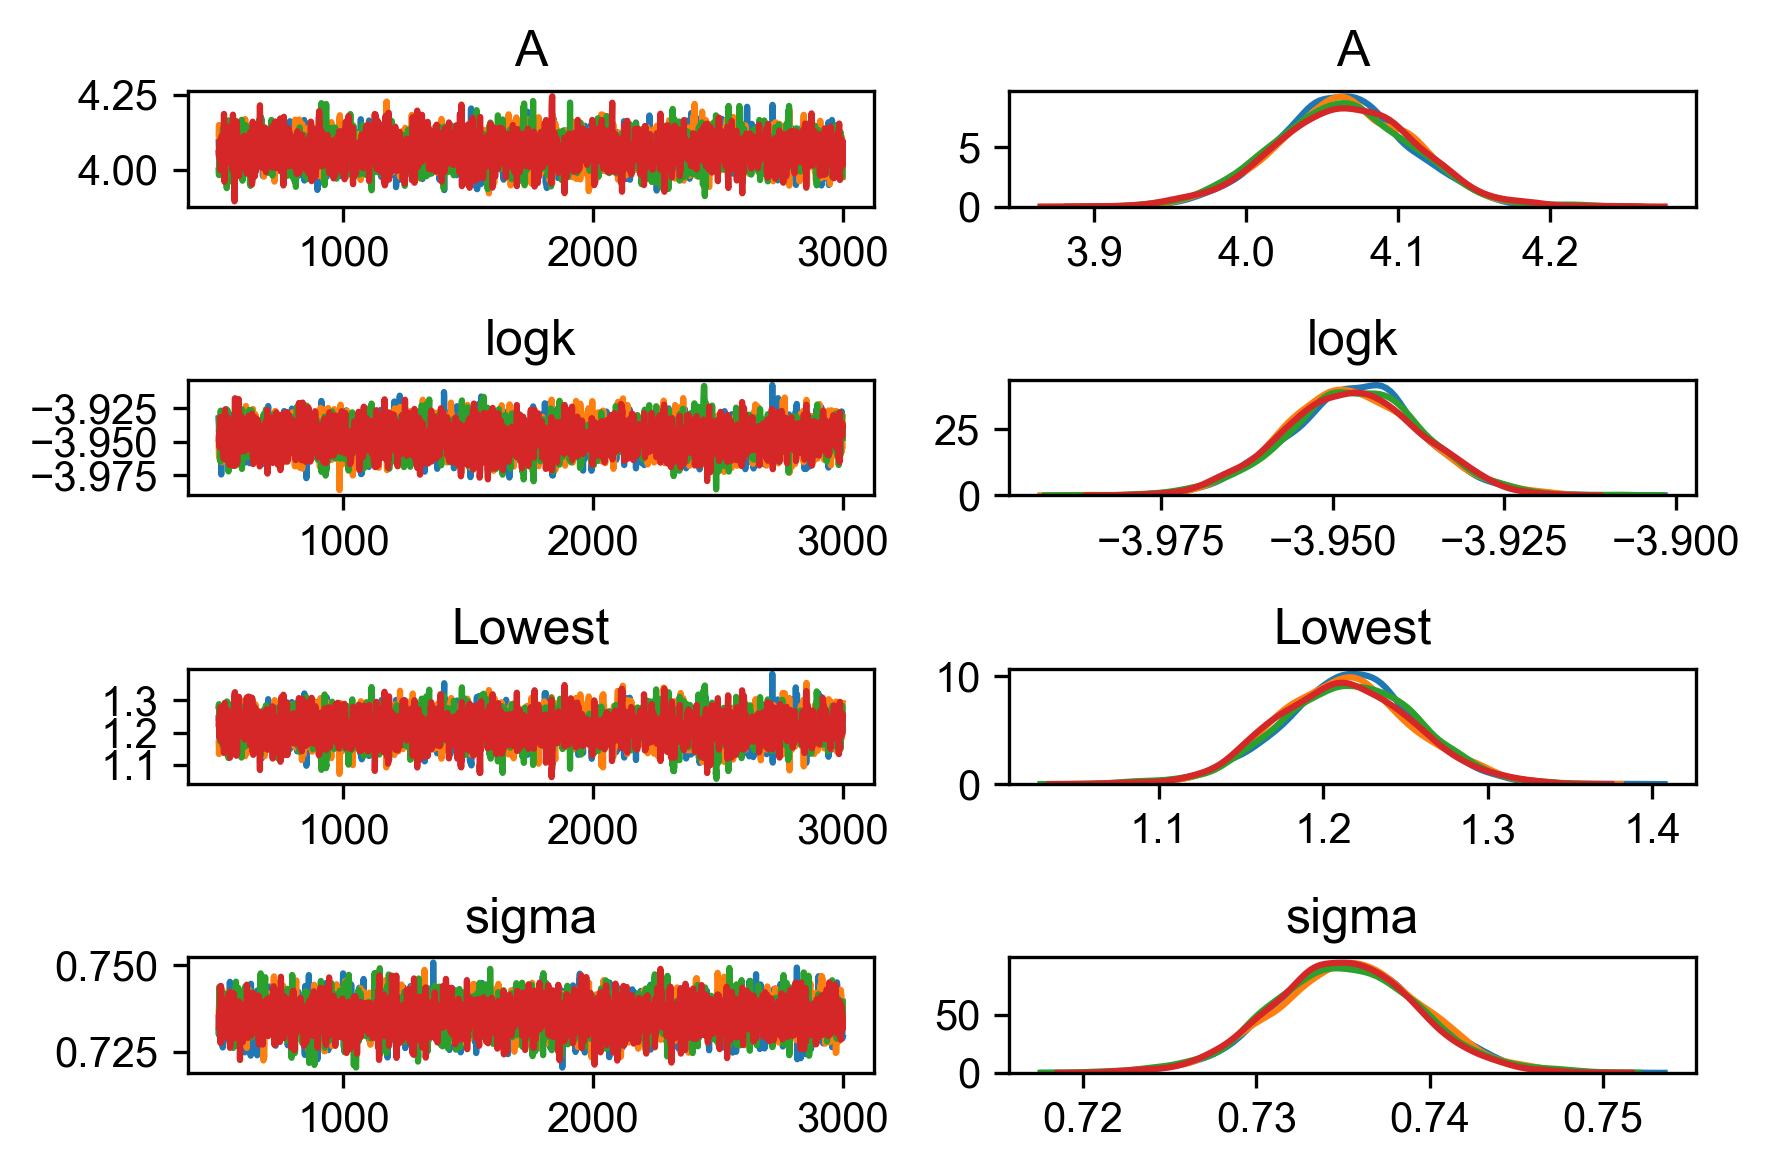

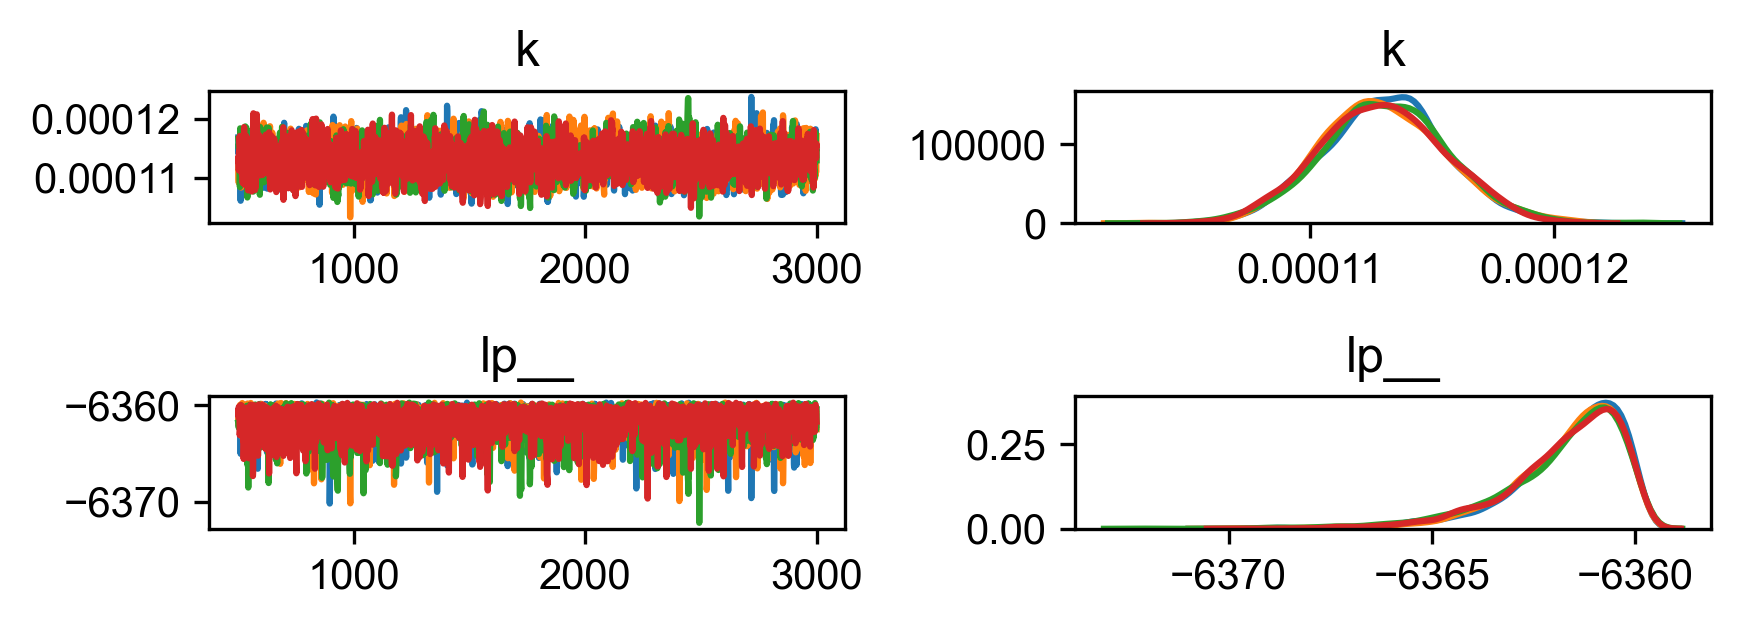

In [18]:
for pg in tqdm(range(num_pages),desc='Progress', leave=False):
    plt.figure(dpi=300)
    pdf = PdfPages("pH change/plot/traceplot/Bayesian Fitting Trace Elder"+str(pg)+".pdf")
    for pos in range(4):
        pi = pg*4 + pos
        if pi >= len(paraname): break
        plt.subplot(4, 2, 2*pos+1)
        plt.tight_layout()
        [plt.plot(iter_range + 1, ms[iter_range,ci,pi], color=palette[ci]) for ci in range(ms.shape[1])]
        plt.title(paraname[pi])
        plt.subplot(4, 2, 2*(pos+1))
        plt.tight_layout()
        [sns.kdeplot(ms[iter_range,ci,pi], color=palette[ci]) for ci in range(ms.shape[1])]
        plt.title(paraname[pi])
    pdf.savefig()
    pdf.close()
    plt.show()

In [19]:
def Fit_Model(t,k,A,Lowest) :
    return Lowest+A*np.exp(-k*t)
def Sample_percentile(t,y_mcmc) :
    prob = [0.5,1,2.5,5,10,20,50,80,90,95,97.5,99,99.5]
    exam = [str(n) for n in prob]
    d = np.zeros((len(time_interval),len(prob)+1), dtype=float)
    for j in range(len(time_interval)):
        d[j,0] = time_interval[j]
        for i in range(len(prob)):
            d[j,i+1] = np.percentile(y_mcmc.iloc[j,:], prob[i],axis=0)
    d = pd.DataFrame(d,dtype="float",columns=["Time"]+exam)
    return d

In [20]:
samples = fit_nuts_pH_change.extract(permuted=True)
time_max = 6
devide = time_max*60*60
time_interval = np.arange(0, time_max*(devide+1)/devide, time_max/devide, dtype="float")
Num_mcmc = len(samples["lp__"])
y_conf_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
y_predict_mcmc_elder = np.zeros((len(time_interval),Num_mcmc), dtype=float)
for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        y_predict_mcmc_elder[j,k] = np.random.normal(Fit_Model(time_interval[j]*3600,
                                                             samples["k"][k],
                                                             samples["A"][k],
                                                             samples["Lowest"][k]),
                                                   samples["sigma"][k]
                                                  )
y_predict_mcmc_elder_df = pd.DataFrame(y_predict_mcmc_elder)
y_predict_percentile_elder = Sample_percentile(time_interval,y_predict_mcmc_elder_df)
y_predict_percentile_elder

,Time,0.5,1,2.5,5,10,20,50,80,90,95,97.5,99,99.5
0,0.000000,3.357331,3.563000,3.851784,4.071043,4.345659,4.669086,5.276537,5.905305,6.235740,6.502854,6.730149,6.991101,7.157435
1,0.000278,3.369891,3.547320,3.847793,4.061915,4.324542,4.653877,5.276980,5.898831,6.226577,6.509094,6.731728,6.993584,7.203655
2,0.000556,3.388889,3.551581,3.826947,4.060598,4.317371,4.650952,5.288158,5.896085,6.204747,6.471837,6.701019,6.934500,7.097115
3,0.000833,3.376963,3.542548,3.797056,4.051348,4.336082,4.666049,5.288241,5.891006,6.218728,6.481993,6.717001,7.007563,7.173771
4,0.001111,3.376491,3.568868,3.828574,4.077244,4.329137,4.651987,5.277778,5.885836,6.218562,6.502625,6.751056,6.989194,7.184395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21596,5.998889,-0.319943,-0.141016,0.117616,0.358809,0.633018,0.962448,1.577493,2.180886,2.495369,2.766912,2.995550,3.275874,3.435963
21597,5.999167,-0.329554,-0.187173,0.106595,0.345512,0.631532,0.948473,1.565812,2.186878,2.506761,2.780833,3.013854,3.320061,3.465913
21598,5.999444,-0.281424,-0.092161,0.149270,0.357127,0.615952,0.934312,1.560949,2.181538,2.507211,2.780982,2.988727,3.250228,3.436121
21599,5.999722,-0.289491,-0.137495,0.128355,0.339847,0.627504,0.946082,1.563080,2.183823,2.504234,2.768658,2.993160,3.263689,3.454957


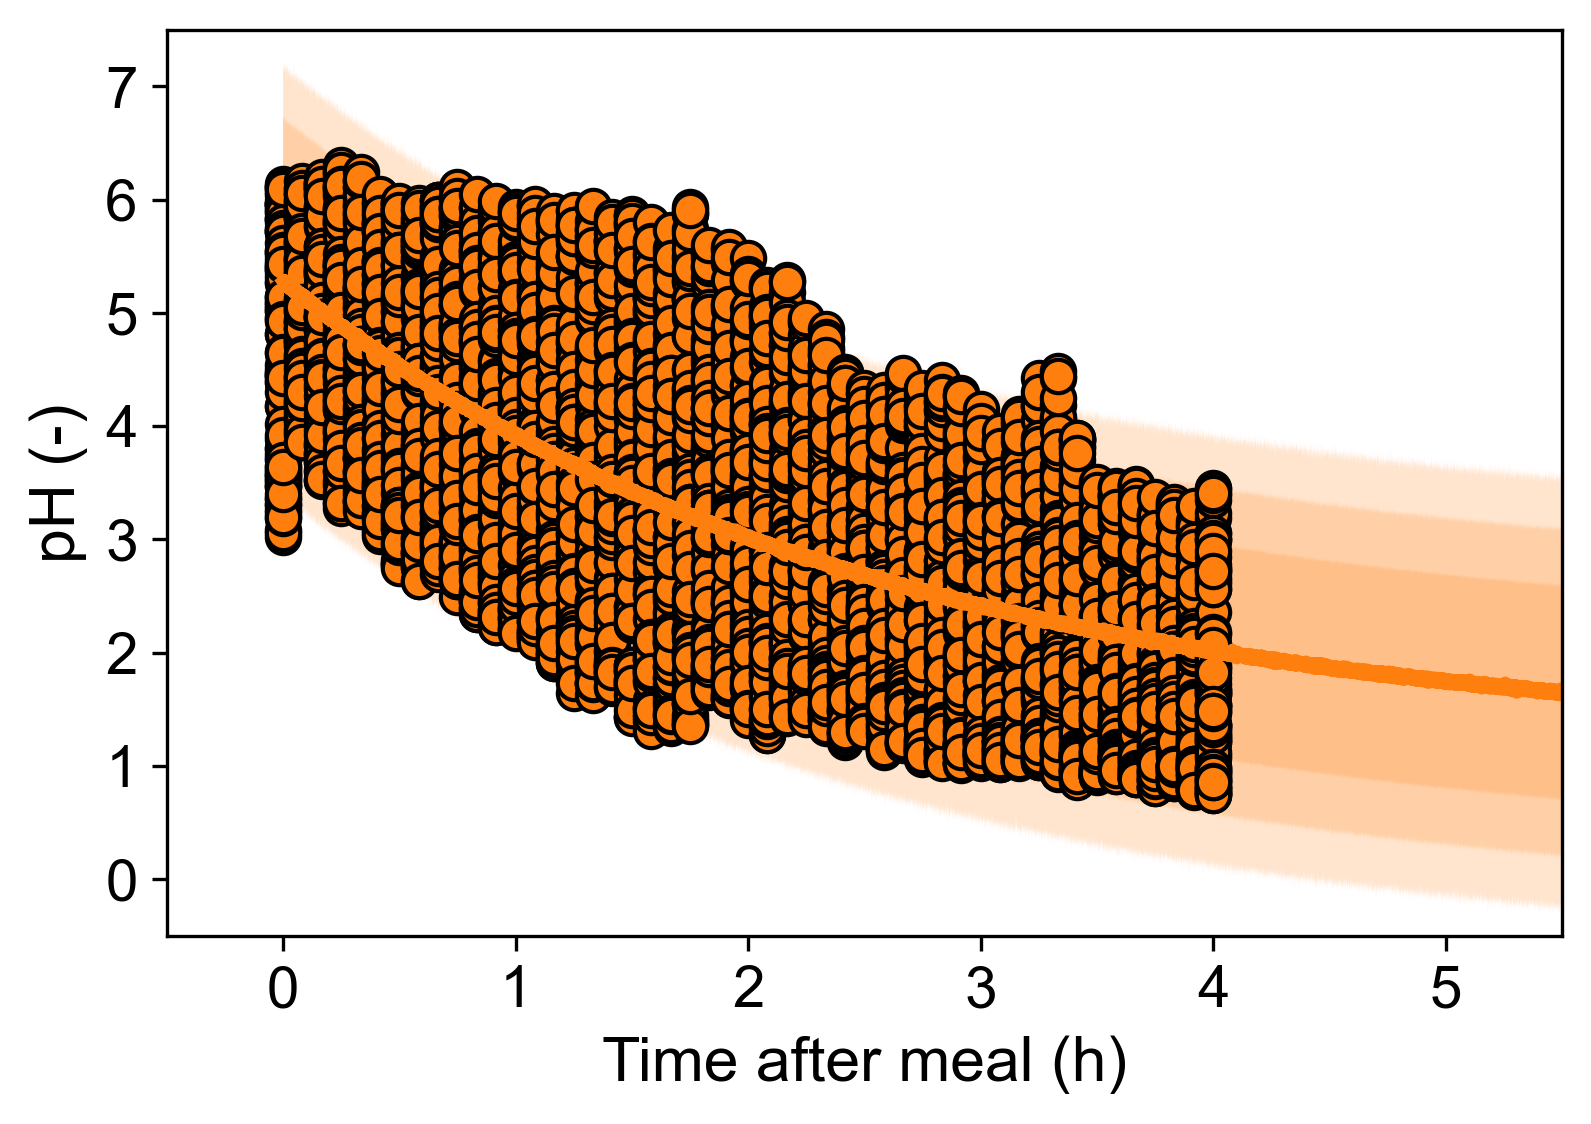

In [21]:
plt.figure(dpi=300)
plt.rcParams["font.family"] = "Arial"
plt.xticks(size=14)
plt.yticks(size=14)


time_max = 6
devide = time_max*60*60
time_interval = np.arange(0, time_max*(devide+1)/devide, time_max/devide, dtype="float")
y_predict_mcmc_elder_df = pd.DataFrame(y_predict_mcmc_elder)
y_predict_percentile_elder = Sample_percentile(time_interval,y_predict_mcmc_elder_df)
y_predict_percentile_elder

pdf = PdfPages("pH change/plot/pH change elder.pdf")

plt.plot(
        observed_pH_elder["Time"]/3600,observed_pH_elder["pH"],
        marker="o",
        markersize=8,
        markerfacecolor=sns.color_palette()[1],
        markeredgecolor="black",
        color="None"
)
plt.plot(y_predict_percentile_elder["Time"],y_predict_percentile_elder["50"],color=sns.color_palette()[1],linewidth=3)
#plt.plot(y_predict_percentile_elder["Time"],y_predict_mcmc_elder[:,2967],color=sns.color_palette()[2],linewidth=1)
#plt.plot(y_predict_percentile_elder["Time"],y_predict_mcmc_elder[:,145],color=sns.color_palette()[3],linewidth=1)
#plt.plot(y_predict_percentile_elder["Time"],y_predict_mcmc_elder[:,8474],color=sns.color_palette()[4],linewidth=1)
plt.fill_between(y_predict_percentile_elder["Time"],y_predict_percentile_elder["0.5"],y_predict_percentile_elder["99.5"],facecolor=sns.color_palette()[1],alpha=0.2)
plt.fill_between(y_predict_percentile_elder["Time"],y_predict_percentile_elder["2.5"],y_predict_percentile_elder["97.5"],facecolor=sns.color_palette()[1],alpha=0.2)
plt.fill_between(y_predict_percentile_elder["Time"],y_predict_percentile_elder["10"],y_predict_percentile_elder["90"],facecolor=sns.color_palette()[1],alpha=0.2)
plt.ylabel("pH (-)",size=15,fontname="Arial")
plt.xlabel("Time after meal (h)",size=15,fontname="Arial")
plt.xticks(size=14)
plt.yticks(size=14)
plt.ylim([-0.5,7.5])
plt.xlim([-0.5,5.5])

pdf.savefig()

pdf.close()

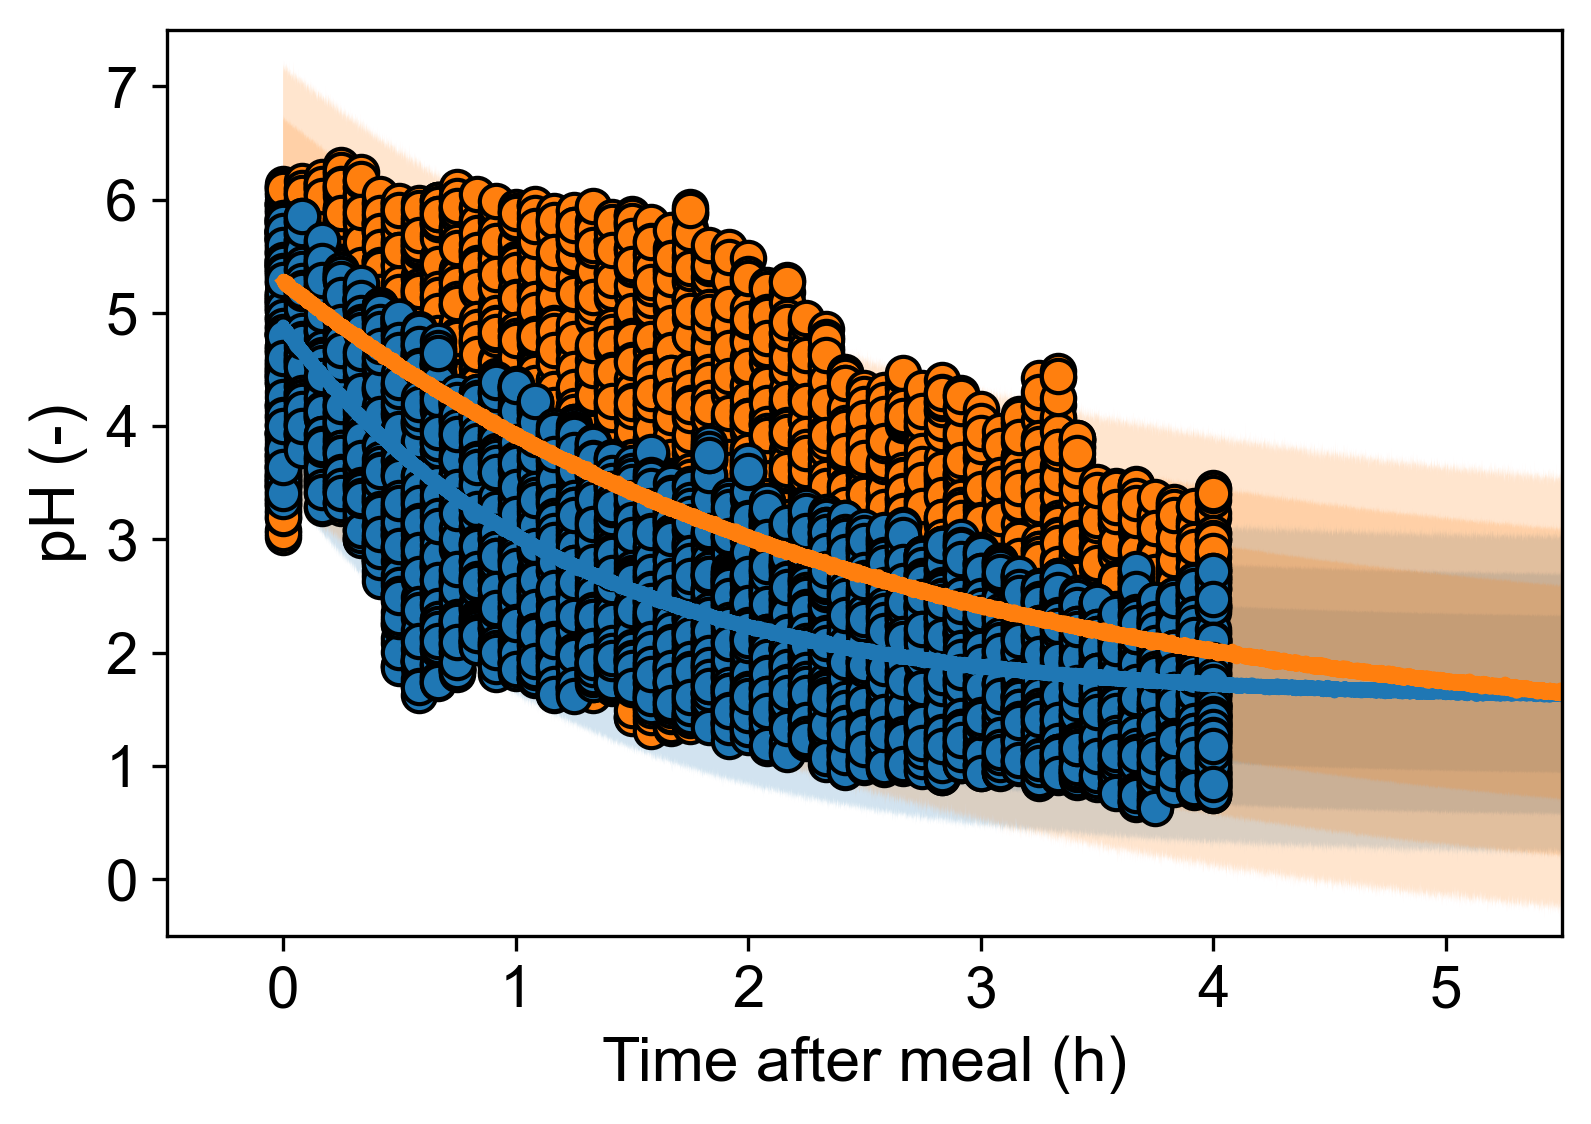

In [22]:
plt.figure(dpi=300)
plt.rcParams["font.family"] = "Arial"
plt.xticks(size=14)
plt.yticks(size=14)


time_max = 6
devide = time_max*60*60
time_interval = np.arange(0, time_max*(devide+1)/devide, time_max/devide, dtype="float")


plt.plot(
        observed_pH_elder["Time"]/3600,observed_pH_elder["pH"],
        marker="o",
        markersize=8,
        markerfacecolor=sns.color_palette()[1],
        markeredgecolor="black",
        color="None"
)

plt.plot(
        observed_pH["Time"]/3600,observed_pH["pH"],
        marker="o",
        markersize=8,
        markerfacecolor=sns.color_palette()[0],
        markeredgecolor="black",
        color="None"
)




plt.fill_between(y_predict_percentile["Time"],y_predict_percentile["0.5"],y_predict_percentile["99.5"],facecolor=sns.color_palette()[0],alpha=0.2)
plt.fill_between(y_predict_percentile["Time"],y_predict_percentile["2.5"],y_predict_percentile["97.5"],facecolor=sns.color_palette()[0],alpha=0.2)
plt.fill_between(y_predict_percentile["Time"],y_predict_percentile["10"],y_predict_percentile["90"],facecolor=sns.color_palette()[0],alpha=0.2)

plt.fill_between(y_predict_percentile_elder["Time"],y_predict_percentile_elder["0.5"],y_predict_percentile_elder["99.5"],facecolor=sns.color_palette()[1],alpha=0.2)
plt.fill_between(y_predict_percentile_elder["Time"],y_predict_percentile_elder["2.5"],y_predict_percentile_elder["97.5"],facecolor=sns.color_palette()[1],alpha=0.2)
plt.fill_between(y_predict_percentile_elder["Time"],y_predict_percentile_elder["10"],y_predict_percentile_elder["90"],facecolor=sns.color_palette()[1],alpha=0.2)

plt.plot(y_predict_percentile["Time"],y_predict_percentile["50"],color=sns.color_palette()[0],linewidth=3)
plt.plot(y_predict_percentile_elder["Time"],y_predict_percentile_elder["50"],color=sns.color_palette()[1],linewidth=3)

plt.ylabel("pH (-)",size=15,fontname="Arial")
plt.xlabel("Time after meal (h)",size=15,fontname="Arial")
plt.ylim([-0.5,7.5])
plt.xlim([-0.5,5.5])

plt.show()

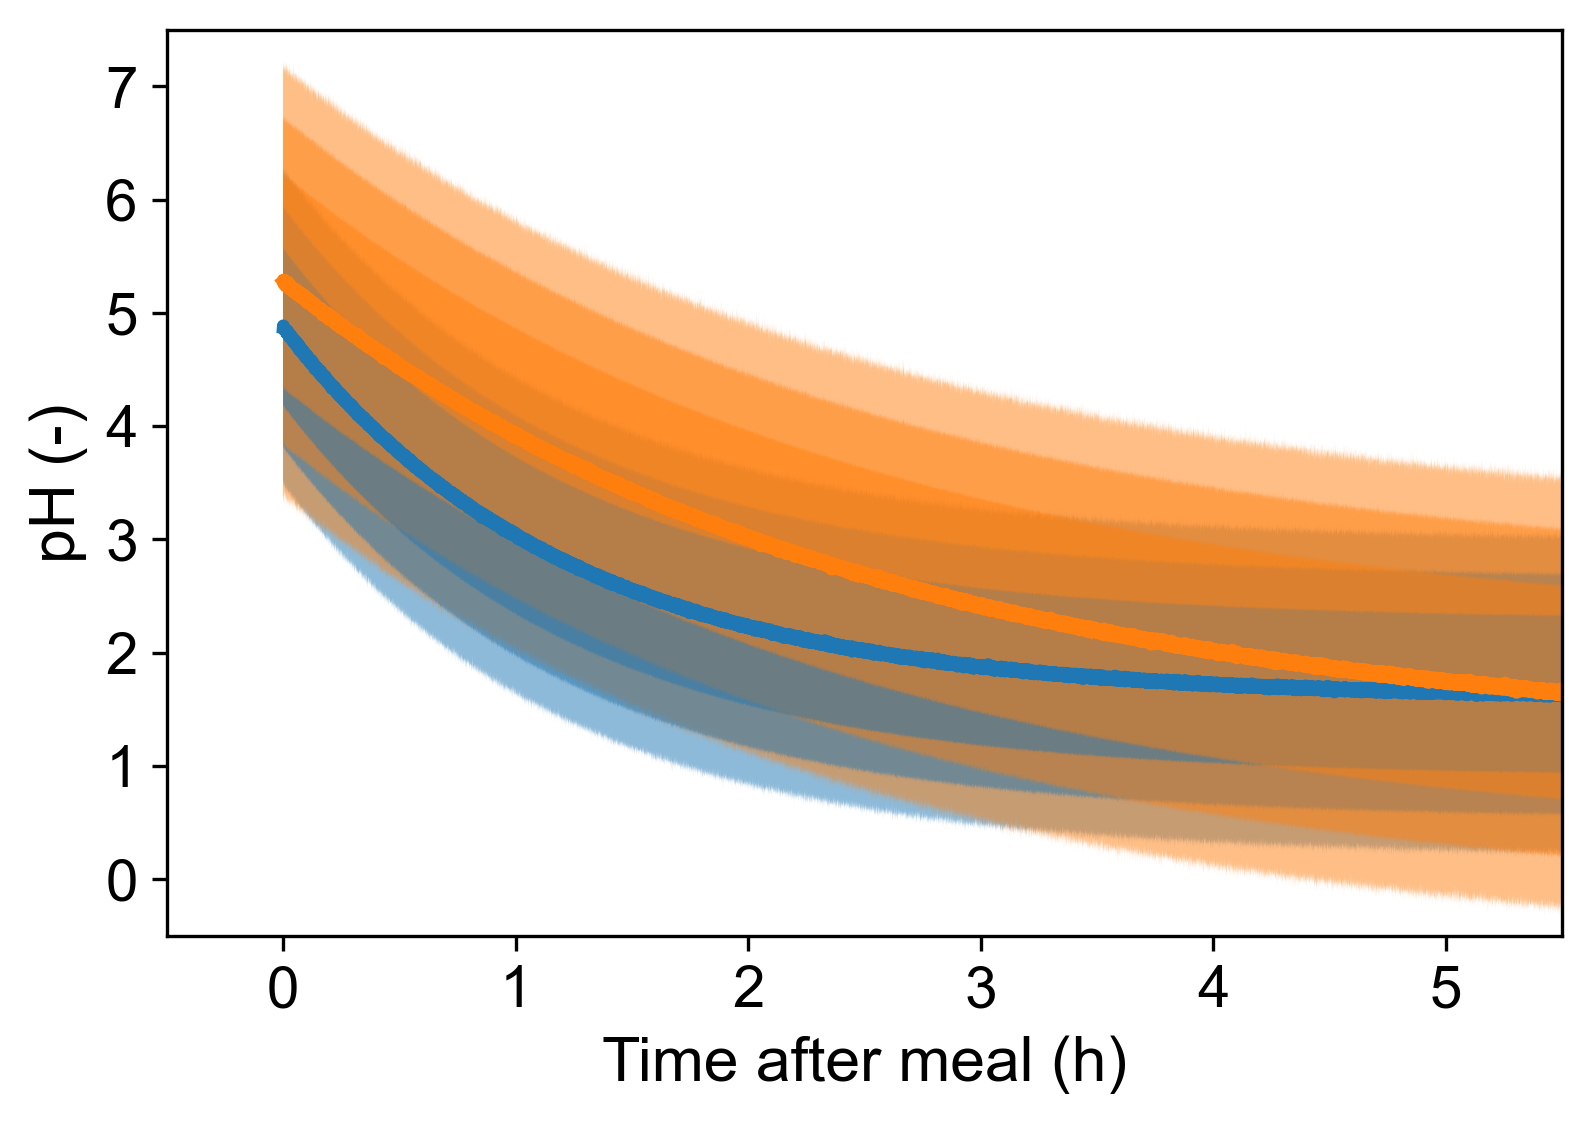

In [23]:
plt.figure(dpi=300)
plt.rcParams["font.family"] = "Arial"
plt.xticks(size=14)
plt.yticks(size=14)


time_max = 6
devide = time_max*60*60
time_interval = np.arange(0, time_max*(devide+1)/devide, time_max/devide, dtype="float")
y_predict_mcmc_df = pd.DataFrame(y_predict_mcmc)
y_predict_percentile = Sample_percentile(time_interval,y_predict_mcmc_df)
y_predict_percentile




plt.plot(y_predict_percentile["Time"],y_predict_percentile["50"],color=sns.color_palette()[0],linewidth=3)
plt.plot(y_predict_percentile_elder["Time"],y_predict_percentile_elder["50"],color=sns.color_palette()[1],linewidth=3)

plt.fill_between(y_predict_percentile["Time"],y_predict_percentile["0.5"],y_predict_percentile["99.5"],facecolor=sns.color_palette()[0],alpha=0.5)
plt.fill_between(y_predict_percentile_elder["Time"],y_predict_percentile_elder["0.5"],y_predict_percentile_elder["99.5"],facecolor=sns.color_palette()[1],alpha=0.5)
plt.fill_between(y_predict_percentile["Time"],y_predict_percentile["2.5"],y_predict_percentile["97.5"],facecolor=sns.color_palette()[0],alpha=0.5)
plt.fill_between(y_predict_percentile_elder["Time"],y_predict_percentile_elder["2.5"],y_predict_percentile_elder["97.5"],facecolor=sns.color_palette()[1],alpha=0.5)
plt.fill_between(y_predict_percentile["Time"],y_predict_percentile["10"],y_predict_percentile["90"],facecolor=sns.color_palette()[0],alpha=0.5)
plt.fill_between(y_predict_percentile_elder["Time"],y_predict_percentile_elder["10"],y_predict_percentile_elder["90"],facecolor=sns.color_palette()[1],alpha=0.5)


plt.ylabel("pH (-)",size=15,fontname="Arial")
plt.xlabel("Time after meal (h)",size=15,fontname="Arial")
plt.ylim([-0.5,7.5])
plt.xlim([-0.5,5.5])

plt.show()

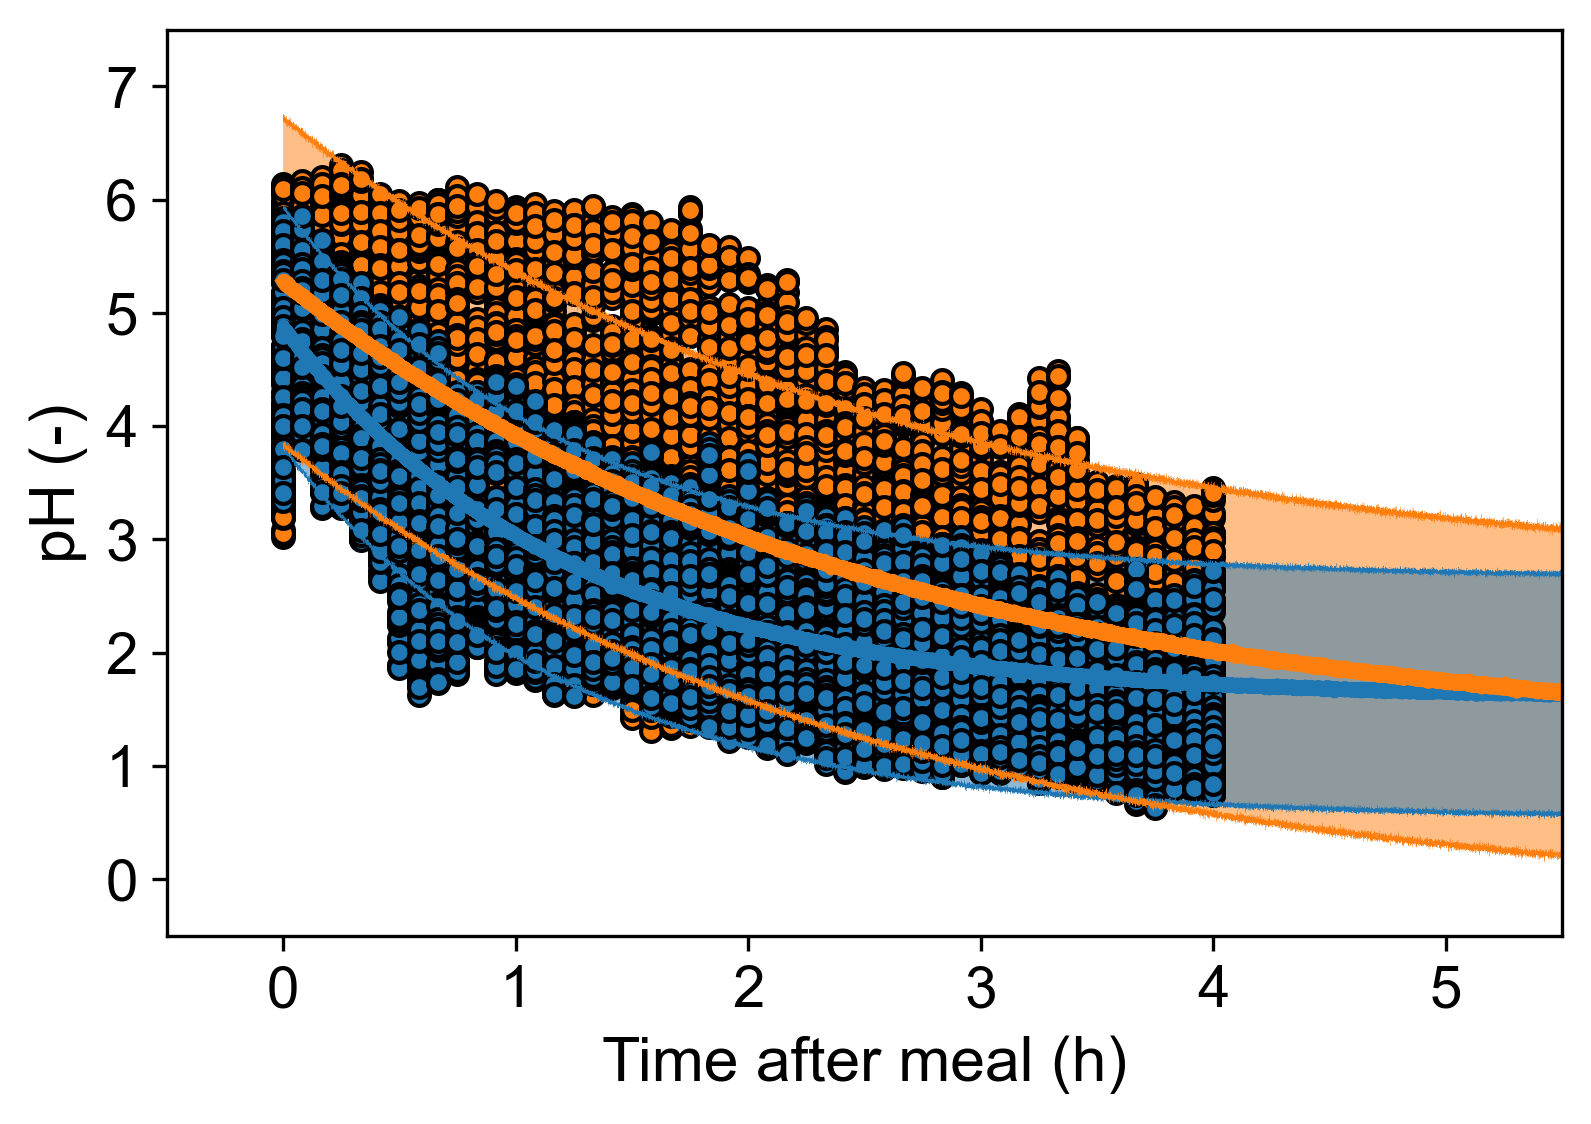

In [24]:
plt.figure(dpi=300)
plt.rcParams["font.family"] = "Arial"
plt.xticks(size=14)
plt.yticks(size=14)


time_max = 6
devide = time_max*60*60
time_interval = np.arange(0, time_max*(devide+1)/devide, time_max/devide, dtype="float")
plt.plot(
        observed_pH_elder["Time"]/3600,observed_pH_elder["pH"],
        marker="o",
        markersize=5,
        markerfacecolor=sns.color_palette()[1],
        markeredgecolor="black",
        color="None"
)

plt.plot(
        observed_pH["Time"]/3600,observed_pH["pH"],
        marker="o",
        markersize=5,
        markerfacecolor=sns.color_palette()[0],
        markeredgecolor="black",
        color="None"
)


plt.fill_between(y_predict_percentile_elder["Time"],y_predict_percentile_elder["2.5"],y_predict_percentile_elder["97.5"],facecolor=sns.color_palette()[1],alpha=0.5)
plt.fill_between(y_predict_percentile["Time"],y_predict_percentile["2.5"],y_predict_percentile["97.5"],facecolor=sns.color_palette()[0],alpha=0.5)


plt.plot(y_predict_percentile["Time"],y_predict_percentile["2.5"],color=sns.color_palette()[0],linewidth=0.1,linestyle='--')
plt.plot(y_predict_percentile_elder["Time"],y_predict_percentile_elder["2.5"],color=sns.color_palette()[1],linewidth=0.1,linestyle='--')
plt.plot(y_predict_percentile["Time"],y_predict_percentile["97.5"],color=sns.color_palette()[0],linewidth=0.1,linestyle='--')
plt.plot(y_predict_percentile_elder["Time"],y_predict_percentile_elder["97.5"],color=sns.color_palette()[1],linewidth=0.1,linestyle='--')


plt.plot(y_predict_percentile["Time"],y_predict_percentile["50"],color=sns.color_palette()[0],linewidth=3)
plt.plot(y_predict_percentile_elder["Time"],y_predict_percentile_elder["50"],color=sns.color_palette()[1],linewidth=3)

plt.ylabel("pH (-)",size=15,fontname="Arial")
plt.xlabel("Time after meal (h)",size=15,fontname="Arial")
plt.ylim([-0.5,7.5])
plt.xlim([-0.5,5.5])

plt.show()